In [1]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
# ==========================================
# 1. LOAD DATA (Original code)
# ==========================================
npz_path = '../data/sampled/Rpt0_N5000.npz'
data = np.load(npz_path, allow_pickle=True)

# Filter diagonal samples
# Note: data['c'] contains the names. We ensure it's a string array.
all_names = data['c']
dia_mask = np.array(['dia' in str(name) for name in all_names])

# Input data (Geometry/physics tensors)
dia_input = data['a'][dia_mask]   # (N_dia, 5000, 9)
dia_output = data['b'][dia_mask]  # (N_dia, 5000, 4)
dia_names = all_names[dia_mask]   # Corresponding names: ['dia_50_14', ...]

print(f"Total diagonal samples: {len(dia_input)}")

Total diagonal samples: 2105


In [3]:
# ==========================================
# 1. PREPARE INPUTS AND OUTPUTS
# ==========================================
print("=" * 70)
print("PREPARING INPUTS AND OUTPUTS")
print("=" * 70)

# Extract only first 3 features from input (geometry: x, y, z)
dia_input_xyz = dia_input[:, :, :3]  # (N_dia, 5000, 3)
dia_output_full = dia_output  # (N_dia, 5000, 4) - ux, uy, uz, stress

print(f"Input shape (XYZ only): {dia_input_xyz.shape}")
print(f"Output shape (ux, uy, uz, stress): {dia_output_full.shape}")

# ==========================================
# 2. TRAIN/TEST SPLIT
# ==========================================
train_idx, test_idx = train_test_split(
    np.arange(len(dia_input_xyz)), 
    test_size=0.2, 
    random_state=42
)

train_input = dia_input_xyz[train_idx]      # (N_train, 5000, 3)
test_input = dia_input_xyz[test_idx]        # (N_test, 5000, 3)
train_output = dia_output_full[train_idx]   # (N_train, 5000, 4)
test_output = dia_output_full[test_idx]     # (N_test, 5000, 4)

print(f"\nTrain input shape: {train_input.shape}")
print(f"Test input shape: {test_input.shape}")
print(f"Train output shape: {train_output.shape}")
print(f"Test output shape: {test_output.shape}")

# ==========================================
# 3. COMPUTE NORMALIZATION STATISTICS (from TRAIN data only)
# ==========================================
print("\n" + "=" * 70)
print("COMPUTING NORMALIZATION STATISTICS (from TRAIN data)")
print("=" * 70)

# Output statistics - per channel
output_min = train_output.min(axis=(0, 1))  # (4,)
output_max = train_output.max(axis=(0, 1))  # (4,)
output_mean = train_output.mean(axis=(0, 1))  # (4,)
output_std = train_output.std(axis=(0, 1))  # (4,)

field_names = ['ux (displacement)', 'uy (displacement)', 'uz (displacement)', 'von Mises stress']

print("\nOUTPUT STATISTICS (TRAINING DATA ONLY):")
print("-" * 70)
for i, fname in enumerate(field_names):
    print(f"\n{fname} (Channel {i}):")
    print(f"  Min:  {output_min[i]:12.6f}")
    print(f"  Max:  {output_max[i]:12.6f}")
    print(f"  Mean: {output_mean[i]:12.6f}")
    print(f"  Std:  {output_std[i]:12.6f}")
    print(f"  Range: {output_max[i] - output_min[i]:12.6f}")

# ==========================================
# 4. NORMALIZE OUTPUTS TO [0, 1]
# ==========================================
print("\n" + "=" * 70)
print("NORMALIZING OUTPUTS TO [0, 1]")
print("=" * 70)

# Normalize using min-max scaling
# normalized = (x - min) / (max - min)
train_output_norm = np.zeros_like(train_output)
test_output_norm = np.zeros_like(test_output)

for i in range(4):
    train_output_norm[:, :, i] = (train_output[:, :, i] - output_min[i]) / (output_max[i] - output_min[i])
    test_output_norm[:, :, i] = (test_output[:, :, i] - output_min[i]) / (output_max[i] - output_min[i])

print("\nNORMALIZED OUTPUT STATISTICS:")
print("-" * 70)
for i, fname in enumerate(field_names):
    print(f"\n{fname} (Channel {i}):")
    print(f"  Train Min:  {train_output_norm[:, :, i].min():.6f}")
    print(f"  Train Max:  {train_output_norm[:, :, i].max():.6f}")
    print(f"  Train Mean: {train_output_norm[:, :, i].mean():.6f}")
    print(f"  Train Std:  {train_output_norm[:, :, i].std():.6f}")
    print(f"  Test Min:   {test_output_norm[:, :, i].min():.6f}")
    print(f"  Test Max:   {test_output_norm[:, :, i].max():.6f}")

print("\n" + "=" * 70)
print("✅ All outputs normalized to [0, 1]")
print("=" * 70)

# ==========================================
# 5. CREATE PYTORCH TENSORS AND DATALOADERS
# ==========================================
from torch.utils.data import TensorDataset, DataLoader

# Convert to tensors (transpose to (B, C, N) for Conv1d)
train_input_tensor = torch.from_numpy(train_input.transpose(0, 2, 1)).float()  # (N_train, 3, 5000)
test_input_tensor = torch.from_numpy(test_input.transpose(0, 2, 1)).float()    # (N_test, 3, 5000)

train_output_tensor = torch.from_numpy(train_output_norm.transpose(0, 2, 1)).float()  # (N_train, 4, 5000)
test_output_tensor = torch.from_numpy(test_output_norm.transpose(0, 2, 1)).float()    # (N_test, 4, 5000)

print("\nTensor shapes for PyTorch:")
print(f"  Train input:  {train_input_tensor.shape}  (Batch, Channels, Points)")
print(f"  Train output: {train_output_tensor.shape}")
print(f"  Test input:   {test_input_tensor.shape}")
print(f"  Test output:  {test_output_tensor.shape}")

# Create datasets and dataloaders
batch_size = 8
train_dataset = TensorDataset(train_input_tensor, train_output_tensor)
test_dataset = TensorDataset(test_input_tensor, test_output_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\n✅ DataLoaders created:")
print(f"   Batch size: {batch_size}")
print(f"   Train batches: {len(train_loader)}")
print(f"   Test batches: {len(test_loader)}")

PREPARING INPUTS AND OUTPUTS
Input shape (XYZ only): (2105, 5000, 3)
Output shape (ux, uy, uz, stress): (2105, 5000, 4)

Train input shape: (1684, 5000, 3)
Test input shape: (421, 5000, 3)
Train output shape: (1684, 5000, 4)
Test output shape: (421, 5000, 4)

COMPUTING NORMALIZATION STATISTICS (from TRAIN data)

OUTPUT STATISTICS (TRAINING DATA ONLY):
----------------------------------------------------------------------

ux (displacement) (Channel 0):
  Min:     -0.737986
  Max:      0.113362
  Mean:    -0.013141
  Std:      0.017515
  Range:     0.851348

uy (displacement) (Channel 1):
  Min:     -0.276773
  Max:      0.274422
  Mean:    -0.000289
  Std:      0.017996
  Range:     0.551195

uz (displacement) (Channel 2):
  Min:     -0.039458
  Max:      0.743882
  Mean:     0.053201
  Std:      0.054152
  Range:     0.783340

von Mises stress (Channel 3):
  Min:      0.000000
  Max:    700.386475
  Mean:    42.861607
  Std:     33.500076
  Range:   700.386475

NORMALIZING OUTPUTS TO 

In [8]:
class PointNetBaseline(nn.Module):
    def __init__(self):
        super(PointNetBaseline, self).__init__()
        
        # ---------------------------------------------------------
        # 1. Local Feature Extraction (Shared MLP)
        # Input: (Batch, 3, N) -> 3 coords
        # The specific channel sizes are derived from Figure 5 in the paper.
        # ---------------------------------------------------------
        self.conv1 = nn.Conv1d(3, 33, 1)
        self.bn1 = nn.BatchNorm1d(33)
        
        self.conv2 = nn.Conv1d(33, 33, 1)
        self.bn2 = nn.BatchNorm1d(33)
        
        self.conv3 = nn.Conv1d(33, 33, 1)
        self.bn3 = nn.BatchNorm1d(33)
        
        # ---------------------------------------------------------
        # 2. Global Feature Extraction
        # These layers process the local features before Max Pooling
        # ---------------------------------------------------------
        self.conv4 = nn.Conv1d(33, 67, 1)
        self.bn4 = nn.BatchNorm1d(67)
        
        self.conv5 = nn.Conv1d(67, 542, 1)
        self.bn5 = nn.BatchNorm1d(542)
        
        # ---------------------------------------------------------
        # 3. Field Prediction (Shared MLP after concatenation)
        # Concatenation input size: 542 (Global) + 33 (Local from conv3) = 575
        # ---------------------------------------------------------
        self.conv6 = nn.Conv1d(575, 271, 1)
        self.bn6 = nn.BatchNorm1d(271)
        
        self.conv7 = nn.Conv1d(271, 135, 1)
        self.bn7 = nn.BatchNorm1d(135)
        
        self.conv8 = nn.Conv1d(135, 67, 1)
        self.bn8 = nn.BatchNorm1d(67)
        
        # Final output: 4 channels (ux, uy, uz, von Mises stress)
        self.conv9 = nn.Conv1d(67, 4, 1)

    def forward(self, x):
        # x shape: (Batch, 8, N)
        
        # --- Local Features ---
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        local_features = F.relu(self.bn3(self.conv3(x))) # Save for concatenation (B, 33, N)
        
        # --- Global Feature Generation ---
        x = F.relu(self.bn4(self.conv4(local_features)))
        x = F.relu(self.bn5(self.conv5(x))) # (B, 542, N)
        
        # Max Pooling over the points (N dimension)
        global_feature = torch.max(x, 2, keepdim=True)[0] # (B, 542, 1)
        
        # Expand global feature to match number of points N
        # (B, 542, 1) -> (B, 542, N)
        global_feature_repeated = global_feature.repeat(1, 1, local_features.size(2))
        
        # --- Concatenation ---
        # Concatenate Global (542) + Local (33) -> (575)
        combined = torch.cat([global_feature_repeated, local_features], dim=1)
        
        # --- Field Prediction ---
        x = F.relu(self.bn6(self.conv6(combined)))
        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        
        # Output Layer with Sigmoid activation as specified in Section 2.3
        x = torch.sigmoid(self.conv9(x))
        
        return x # Output shape: (Batch, 4, N)

In [9]:
# ==========================================
# 6. INSTANTIATE MODEL
# ==========================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nDevice: {device}")

model = PointNetBaseline()
model = model.to(device)

print("\n" + "=" * 70)
print("MODEL ARCHITECTURE")
print("=" * 70)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")


Device: cuda

MODEL ARCHITECTURE
PointNetBaseline(
  (conv1): Conv1d(3, 33, kernel_size=(1,), stride=(1,))
  (bn1): BatchNorm1d(33, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(33, 33, kernel_size=(1,), stride=(1,))
  (bn2): BatchNorm1d(33, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(33, 33, kernel_size=(1,), stride=(1,))
  (bn3): BatchNorm1d(33, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(33, 67, kernel_size=(1,), stride=(1,))
  (bn4): BatchNorm1d(67, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv1d(67, 542, kernel_size=(1,), stride=(1,))
  (bn5): BatchNorm1d(542, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv1d(575, 271, kernel_size=(1,), stride=(1,))
  (bn6): BatchNorm1d(271, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv7): Conv1d(271, 135, kernel_size=(1,), stride=(1,))
  (bn7): 

In [10]:
# ==========================================
# 7. TRAINING SETUP
# ==========================================
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10, verbose=True
)

num_epochs = 150
patience = 25
best_val_loss = float('inf')
patience_counter = 0

print("\n" + "=" * 70)
print("TRAINING CONFIGURATION")
print("=" * 70)
print(f"Model: PointNetBaseline")
print(f"Device: {device}")
print(f"Loss: MSELoss (on normalized [0, 1] outputs)")
print(f"Optimizer: Adam (lr=1e-3, weight_decay=1e-5)")
print(f"Scheduler: ReduceLROnPlateau")
print(f"Epochs: {num_epochs}")
print(f"Early stopping patience: {patience}")
print(f"Batch size: {batch_size}")
print("=" * 70)


TRAINING CONFIGURATION
Model: PointNetBaseline
Device: cuda
Loss: MSELoss (on normalized [0, 1] outputs)
Optimizer: Adam (lr=1e-3, weight_decay=1e-5)
Scheduler: ReduceLROnPlateau
Epochs: 150
Early stopping patience: 25
Batch size: 8


In [11]:
# ==========================================
# 8. TRAINING LOOP
# ==========================================
train_losses = []
test_losses = []

print("\nStarting training...\n")

for epoch in range(num_epochs):
    # --- TRAINING PHASE ---
    model.train()
    train_loss = 0.0
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device)  # (B, 3, 5000)
        targets = targets.to(device)  # (B, 4, 5000)
        
        # Forward pass
        outputs = model(inputs)  # (B, 4, 5000)
        loss = criterion(outputs, targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # --- VALIDATION PHASE ---
    model.eval()
    test_loss = 0.0
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
    
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    
    # Learning rate scheduling
    scheduler.step(test_loss)
    
    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'pointnet_best_model.pth')
    else:
        patience_counter += 1
    
    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:3d}/{num_epochs} | Train Loss: {train_loss:.6f} | Test Loss: {test_loss:.6f} | LR: {optimizer.param_groups[0]['lr']:.2e}")
    
    if patience_counter >= patience:
        print(f"\n⚠️  Early stopping at epoch {epoch+1}")
        break

# Load best model
model.load_state_dict(torch.load('pointnet_best_model.pth'))

print("\n" + "=" * 70)
print("TRAINING COMPLETED")
print("=" * 70)
print(f"Final train loss: {train_losses[-1]:.6f}")
print(f"Best test loss: {best_val_loss:.6f}")
print("=" * 70)


Starting training...

Epoch  10/150 | Train Loss: 0.000348 | Test Loss: 0.000442 | LR: 1.00e-03
Epoch  20/150 | Train Loss: 0.000346 | Test Loss: 0.000317 | LR: 1.00e-03
Epoch  30/150 | Train Loss: 0.000337 | Test Loss: 0.000352 | LR: 1.00e-03
Epoch  40/150 | Train Loss: 0.000313 | Test Loss: 0.000316 | LR: 1.00e-03
Epoch  50/150 | Train Loss: 0.000262 | Test Loss: 0.000328 | LR: 5.00e-04
Epoch  60/150 | Train Loss: 0.000259 | Test Loss: 0.000249 | LR: 5.00e-04
Epoch  70/150 | Train Loss: 0.000257 | Test Loss: 0.000252 | LR: 5.00e-04
Epoch  80/150 | Train Loss: 0.000250 | Test Loss: 0.000323 | LR: 5.00e-04
Epoch  90/150 | Train Loss: 0.000217 | Test Loss: 0.000263 | LR: 2.50e-04
Epoch 100/150 | Train Loss: 0.000212 | Test Loss: 0.000252 | LR: 2.50e-04
Epoch 110/150 | Train Loss: 0.000219 | Test Loss: 0.000228 | LR: 2.50e-04
Epoch 120/150 | Train Loss: 0.000189 | Test Loss: 0.000171 | LR: 1.25e-04
Epoch 130/150 | Train Loss: 0.000190 | Test Loss: 0.000206 | LR: 6.25e-05
Epoch 140/150 |

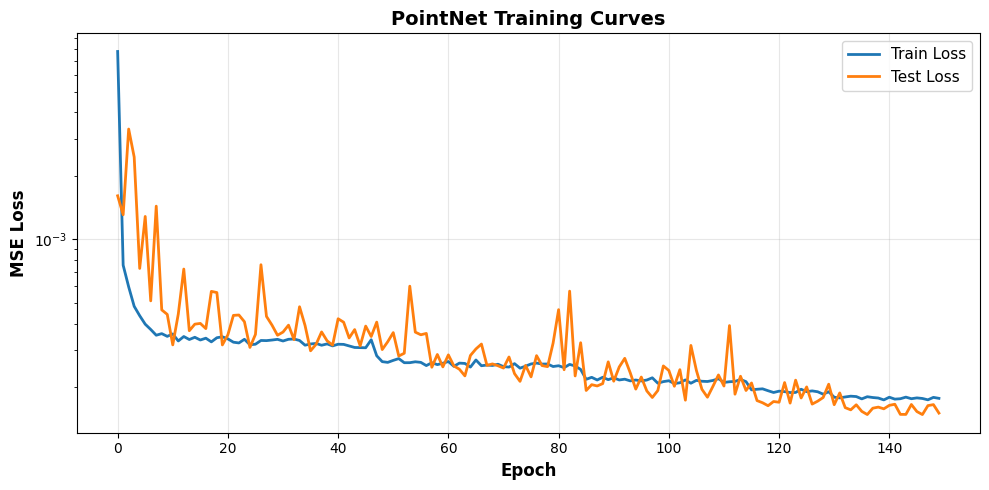

In [12]:
# ==========================================
# 9. PLOT TRAINING CURVES
# ==========================================
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(train_losses, label='Train Loss', linewidth=2, color='#1f77b4')
ax.plot(test_losses, label='Test Loss', linewidth=2, color='#ff7f0e')

ax.set_xlabel('Epoch', fontweight='bold', fontsize=12)
ax.set_ylabel('MSE Loss', fontweight='bold', fontsize=12)
ax.set_title('PointNet Training Curves', fontweight='bold', fontsize=14)
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
ax.set_yscale('log')

plt.tight_layout()
plt.show()


EVALUATING MODEL ON TEST SET

Test predictions shape: (421, 4, 5000)
Test targets shape: (421, 4, 5000)

R² SCORES (NORMALIZED [0, 1] SPACE)

ux (displacement) (Channel 0):
  R² Score:  0.915209
  RMSE:      0.005893
  MAE:       0.003668

uy (displacement) (Channel 1):
  R² Score:  0.946692
  RMSE:      0.007352
  MAE:       0.004371

uz (displacement) (Channel 2):
  R² Score:  0.977682
  RMSE:      0.010205
  MAE:       0.006477

von Mises stress (Channel 3):
  R² Score:  0.824793
  RMSE:      0.019923
  MAE:       0.013076

OVERALL SUMMARY (Normalized Space)
Mean R²:   0.916094
Mean RMSE: 0.010843
Mean MAE:  0.006898


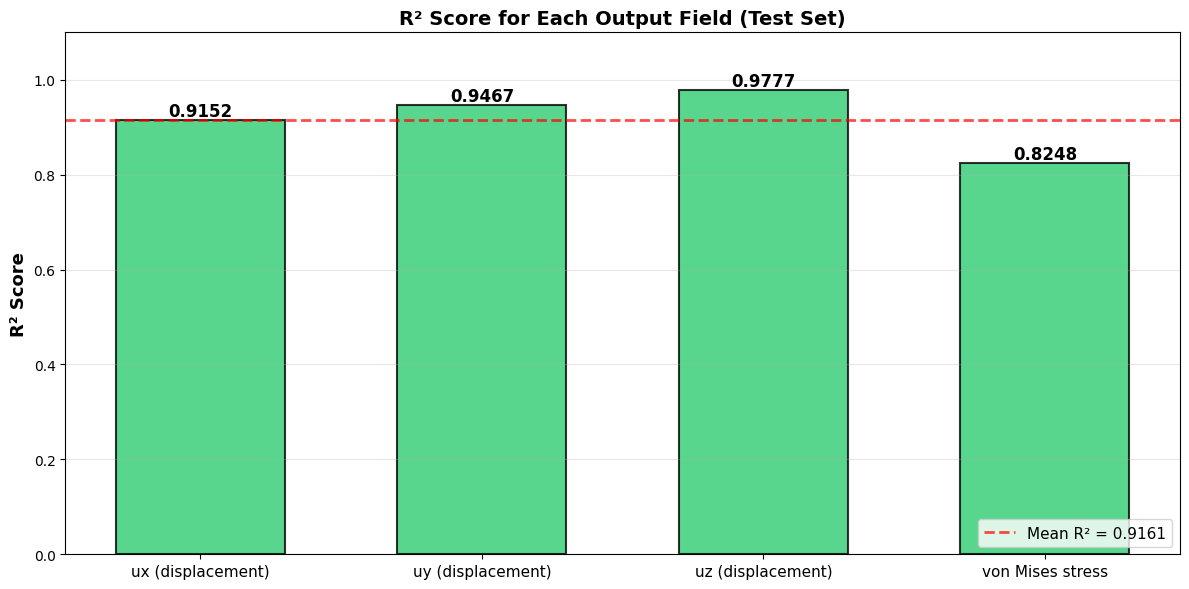

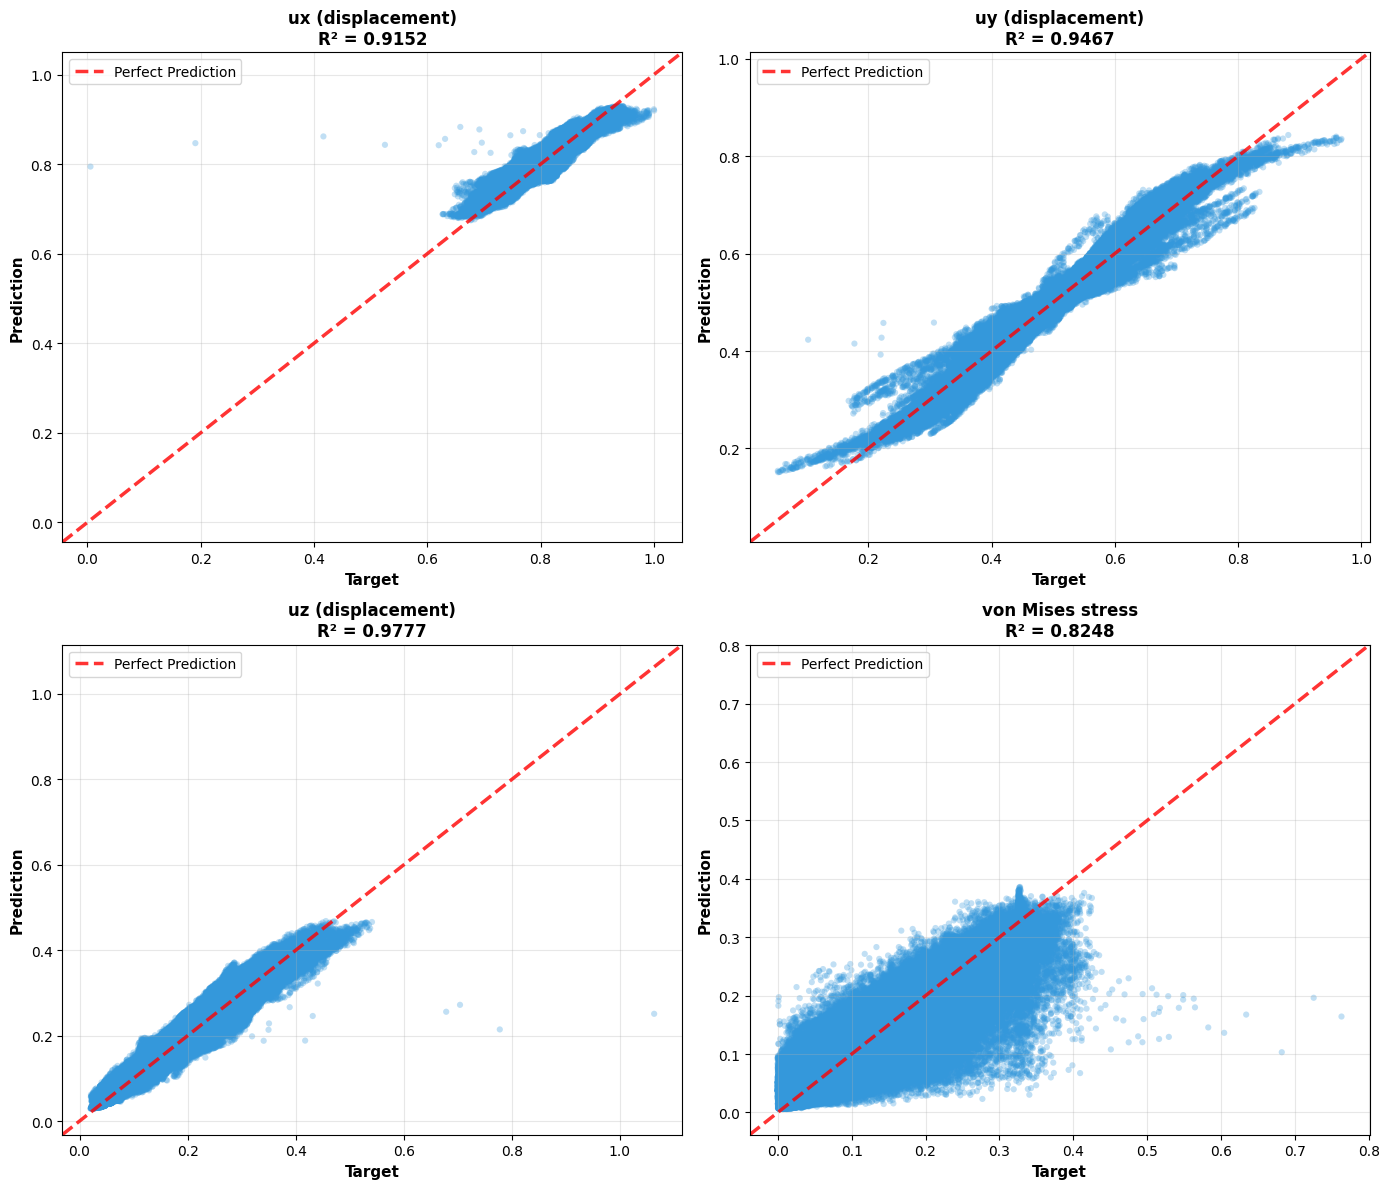

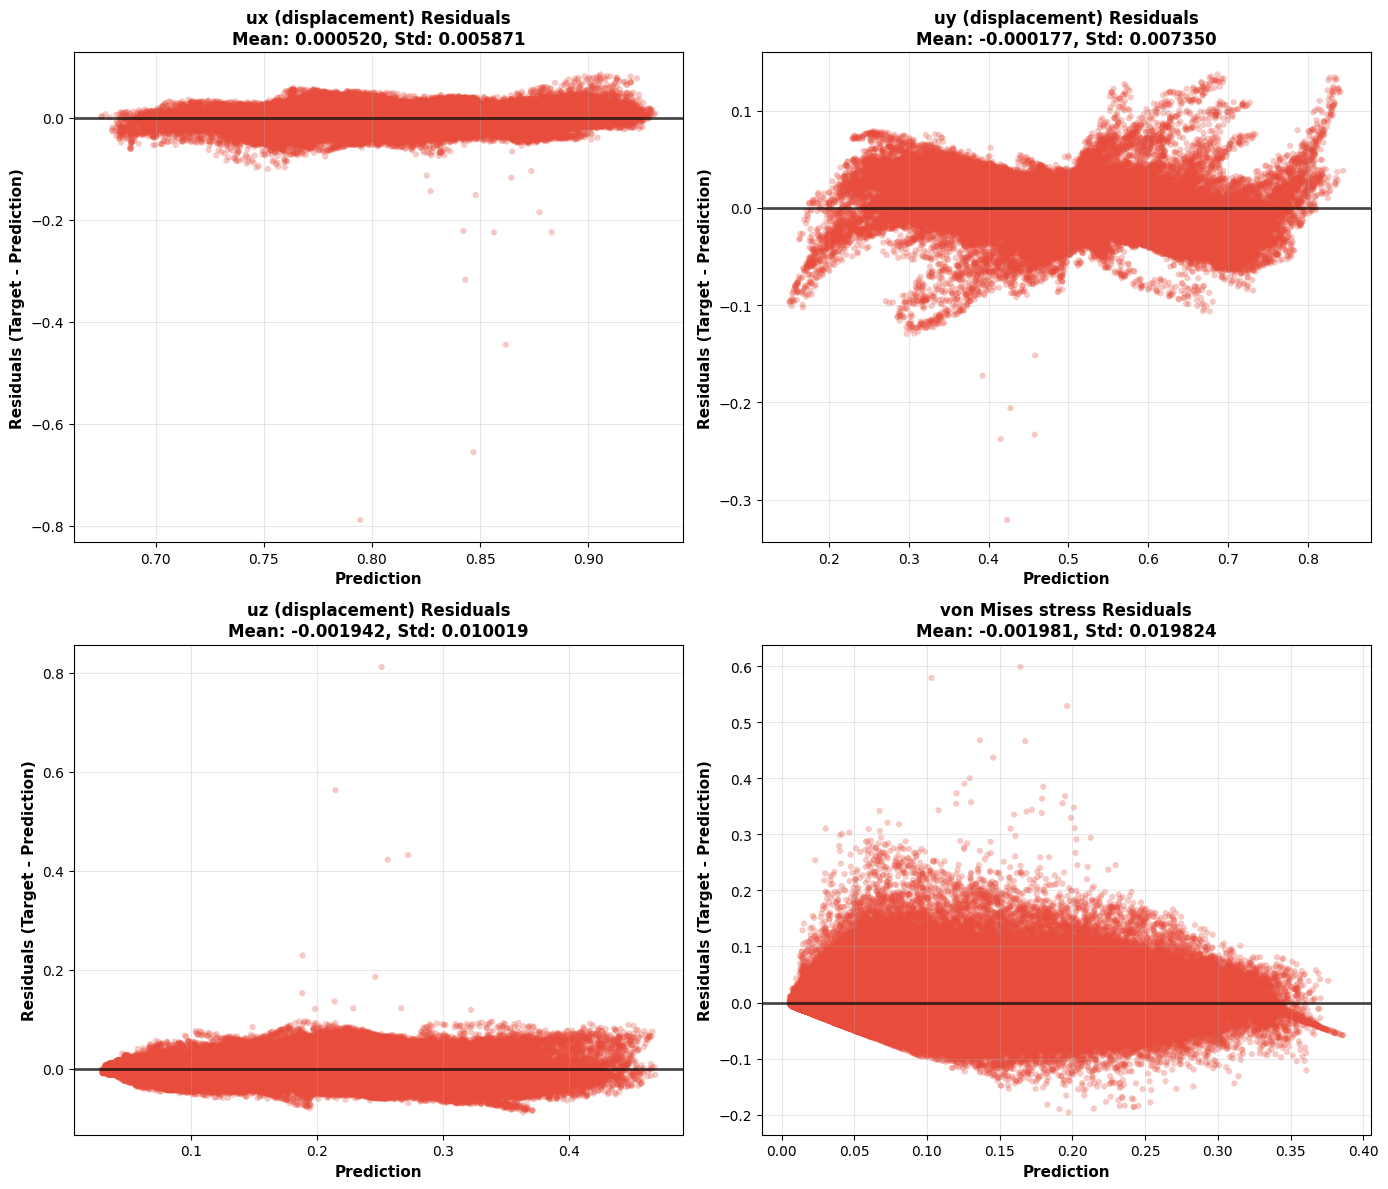

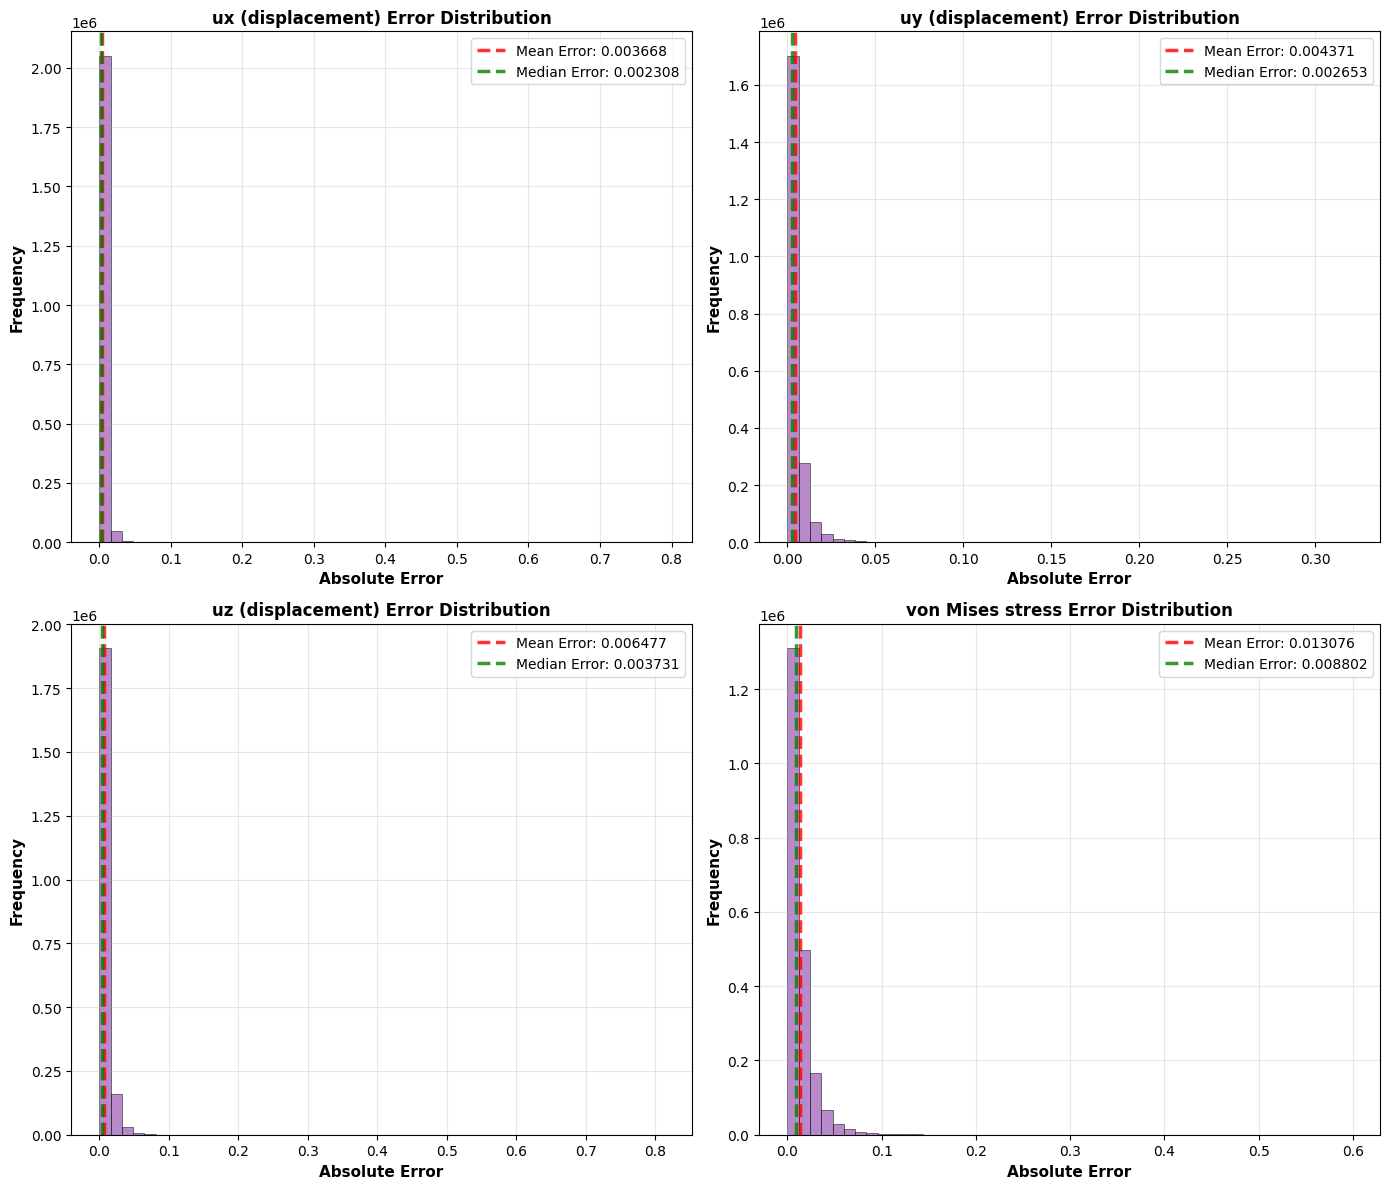


DETAILED METRICS SUMMARY

Field                          R²           RMSE         MAE         
----------------------------------------------------------------------
ux (displacement)              0.915209     0.005893     0.003668    
uy (displacement)              0.946692     0.007352     0.004371    
uz (displacement)              0.977682     0.010205     0.006477    
von Mises stress               0.824793     0.019923     0.013076    
----------------------------------------------------------------------
MEAN                           0.916094     0.010843     0.006898    


In [13]:
# ==========================================
# 10. EVALUATION: R² SCORE FOR EACH FIELD
# ==========================================
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

print("\n" + "=" * 70)
print("EVALUATING MODEL ON TEST SET")
print("=" * 70)

model.eval()

# ==========================================
# COLLECT TEST PREDICTIONS
# ==========================================
test_predictions = []
test_targets_list = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        outputs = model(inputs)  # (B, 4, 5000)
        test_predictions.append(outputs.cpu().numpy())
        test_targets_list.append(targets.cpu().numpy())

# Concatenate all batches: (N_test, 4, 5000)
test_pred = np.concatenate(test_predictions, axis=0)
test_targ = np.concatenate(test_targets_list, axis=0)

print(f"\nTest predictions shape: {test_pred.shape}")
print(f"Test targets shape: {test_targ.shape}")

# ==========================================
# COMPUTE R² FOR EACH FIELD (NORMALIZED [0,1])
# ==========================================
print("\n" + "=" * 70)
print("R² SCORES (NORMALIZED [0, 1] SPACE)")
print("=" * 70)

field_names = ['ux (displacement)', 'uy (displacement)', 'uz (displacement)', 'von Mises stress']
r2_scores = []
rmse_scores = []
mae_scores = []

for i, fname in enumerate(field_names):
    # Extract predictions and targets for this field across all points
    # Shape: (N_test, 5000)
    pred = test_pred[:, i, :].flatten()
    target = test_targ[:, i, :].flatten()
    
    r2 = r2_score(target, pred)
    rmse = np.sqrt(mean_squared_error(target, pred))
    mae = mean_absolute_error(target, pred)
    
    r2_scores.append(r2)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    
    print(f"\n{fname} (Channel {i}):")
    print(f"  R² Score:  {r2:8.6f}")
    print(f"  RMSE:      {rmse:8.6f}")
    print(f"  MAE:       {mae:8.6f}")

print("\n" + "=" * 70)
print("OVERALL SUMMARY (Normalized Space)")
print("=" * 70)
print(f"Mean R²:   {np.mean(r2_scores):.6f}")
print(f"Mean RMSE: {np.mean(rmse_scores):.6f}")
print(f"Mean MAE:  {np.mean(mae_scores):.6f}")
print("=" * 70)

# ==========================================
# VISUALIZATION 1: R² SCORES BAR CHART
# ==========================================
fig, ax = plt.subplots(figsize=(12, 6))

x_pos = np.arange(len(field_names))
width = 0.6

bars = ax.bar(x_pos, r2_scores, width, color='#2ecc71', alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for i, (bar, r2) in enumerate(zip(bars, r2_scores)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{r2:.4f}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('R² Score', fontweight='bold', fontsize=13)
ax.set_title('R² Score for Each Output Field (Test Set)', fontweight='bold', fontsize=14)
ax.set_xticks(x_pos)
ax.set_xticklabels(field_names, fontsize=11)
ax.set_ylim([0, 1.1])
ax.axhline(y=np.mean(r2_scores), color='red', linestyle='--', linewidth=2, 
           label=f'Mean R² = {np.mean(r2_scores):.4f}', alpha=0.7)
ax.grid(axis='y', alpha=0.3)
ax.legend(fontsize=11, loc='lower right')

plt.tight_layout()
plt.show()

# ==========================================
# VISUALIZATION 2: PREDICTION vs TARGET (per field)
# ==========================================
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for i, (ax, fname) in enumerate(zip(axes, field_names)):
    pred = test_pred[:, i, :].flatten()
    target = test_targ[:, i, :].flatten()
    
    # Scatter plot
    ax.scatter(target, pred, alpha=0.3, s=20, edgecolors='none', color='#3498db')
    
    # Perfect prediction line
    min_val = min(target.min(), pred.min())
    max_val = max(target.max(), pred.max())
    margin = (max_val - min_val) * 0.05
    ax.plot([min_val - margin, max_val + margin], [min_val - margin, max_val + margin], 
            'r--', linewidth=2.5, label='Perfect Prediction', alpha=0.8)
    
    ax.set_xlabel('Target', fontweight='bold', fontsize=11)
    ax.set_ylabel('Prediction', fontweight='bold', fontsize=11)
    ax.set_title(f'{fname}\nR² = {r2_scores[i]:.4f}', fontweight='bold', fontsize=12)
    ax.grid(alpha=0.3)
    ax.legend(fontsize=10)
    ax.set_xlim([min_val - margin, max_val + margin])
    ax.set_ylim([min_val - margin, max_val + margin])

plt.tight_layout()
plt.show()

# ==========================================
# VISUALIZATION 3: RESIDUALS (per field)
# ==========================================
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for i, (ax, fname) in enumerate(zip(axes, field_names)):
    pred = test_pred[:, i, :].flatten()
    target = test_targ[:, i, :].flatten()
    residuals = target - pred
    
    # Scatter plot of residuals
    ax.scatter(pred, residuals, alpha=0.3, s=20, edgecolors='none', color='#e74c3c')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=2, alpha=0.7)
    
    ax.set_xlabel('Prediction', fontweight='bold', fontsize=11)
    ax.set_ylabel('Residuals (Target - Prediction)', fontweight='bold', fontsize=11)
    ax.set_title(f'{fname} Residuals\nMean: {residuals.mean():.6f}, Std: {residuals.std():.6f}', 
                fontweight='bold', fontsize=12)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ==========================================
# VISUALIZATION 4: HISTOGRAM OF ERRORS
# ==========================================
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for i, (ax, fname) in enumerate(zip(axes, field_names)):
    pred = test_pred[:, i, :].flatten()
    target = test_targ[:, i, :].flatten()
    errors = np.abs(target - pred)
    
    ax.hist(errors, bins=50, color='#9b59b6', alpha=0.7, edgecolor='black', linewidth=0.5)
    ax.axvline(errors.mean(), color='red', linestyle='--', linewidth=2.5, 
              label=f'Mean Error: {errors.mean():.6f}', alpha=0.8)
    ax.axvline(np.median(errors), color='green', linestyle='--', linewidth=2.5, 
              label=f'Median Error: {np.median(errors):.6f}', alpha=0.8)
    
    ax.set_xlabel('Absolute Error', fontweight='bold', fontsize=11)
    ax.set_ylabel('Frequency', fontweight='bold', fontsize=11)
    ax.set_title(f'{fname} Error Distribution', fontweight='bold', fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ==========================================
# CREATE SUMMARY TABLE
# ==========================================
print("\n" + "=" * 70)
print("DETAILED METRICS SUMMARY")
print("=" * 70)
print(f"\n{'Field':<30} {'R²':<12} {'RMSE':<12} {'MAE':<12}")
print("-" * 70)

for i, fname in enumerate(field_names):
    print(f"{fname:<30} {r2_scores[i]:<12.6f} {rmse_scores[i]:<12.6f} {mae_scores[i]:<12.6f}")

print("-" * 70)
print(f"{'MEAN':<30} {np.mean(r2_scores):<12.6f} {np.mean(rmse_scores):<12.6f} {np.mean(mae_scores):<12.6f}")
print("=" * 70)

In [ ]:
# ==========================================
# 11. VISUALIZE POINT CLOUDS WITH VON MISES STRESS
# ==========================================
print("\n" + "=" * 70)
print("VISUALIZING POINT CLOUDS: VON MISES STRESS")
print("=" * 70)

# Select a few random test samples to visualize
num_samples_to_plot = 4
sample_indices = np.random.choice(len(test_input), size=num_samples_to_plot, replace=False)

print(f"\nVisualizing {num_samples_to_plot} random test samples...")
print(f"Sample indices: {sample_indices}")

for sample_idx in sample_indices:
    # Get the input geometry (original XYZ coordinates)
    geom = test_input[sample_idx]  # (5000, 3)
    
    # Get predictions and targets (in normalized space [0, 1])
    pred_norm = test_pred[sample_idx]  # (4, 5000)
    targ_norm = test_targ[sample_idx]  # (4, 5000)
    
    # Extract von Mises stress (channel 3)
    stress_pred_norm = pred_norm[3, :]  # (5000,) - normalized [0, 1]
    stress_targ_norm = targ_norm[3, :]  # (5000,) - normalized [0, 1]
    
    # Denormalize stress values back to original scale
    stress_pred_original = stress_pred_norm * (output_max[3] - output_min[3]) + output_min[3]
    stress_targ_original = stress_targ_norm * (output_max[3] - output_min[3]) + output_min[3]
    
    # Create side-by-side visualization
    fig = plt.figure(figsize=(16, 6))
    
    # --- SUBPLOT 1: Ground Truth Stress ---
    ax1 = fig.add_subplot(131, projection='3d')
    
    # Scatter plot with color mapping
    scatter1 = ax1.scatter(geom[:, 0], geom[:, 1], geom[:, 2], 
                          c=stress_targ_original, cmap='RdYlBu_r', s=20, 
                          alpha=0.8, edgecolors='none')
    
    ax1.set_xlabel('X', fontweight='bold', fontsize=10)
    ax1.set_ylabel('Y', fontweight='bold', fontsize=10)
    ax1.set_zlabel('Z', fontweight='bold', fontsize=10)
    ax1.set_title('Ground Truth von Mises Stress', fontweight='bold', fontsize=12, color='#2ecc71')
    ax1.view_init(elev=20, azim=45)
    
    cbar1 = plt.colorbar(scatter1, ax=ax1, pad=0.1, shrink=0.8)
    cbar1.set_label('Stress (MPa)', fontweight='bold', fontsize=9)
    cbar1.formatter.set_powerlimits((0, 0))
    
    # --- SUBPLOT 2: Predicted Stress ---
    ax2 = fig.add_subplot(132, projection='3d')
    
    scatter2 = ax2.scatter(geom[:, 0], geom[:, 1], geom[:, 2], 
                          c=stress_pred_original, cmap='RdYlBu_r', s=20, 
                          alpha=0.8, edgecolors='none')
    
    ax2.set_xlabel('X', fontweight='bold', fontsize=10)
    ax2.set_ylabel('Y', fontweight='bold', fontsize=10)
    ax2.set_zlabel('Z', fontweight='bold', fontsize=10)
    ax2.set_title('Predicted von Mises Stress', fontweight='bold', fontsize=12, color='#3498db')
    ax2.view_init(elev=20, azim=45)
    
    cbar2 = plt.colorbar(scatter2, ax=ax2, pad=0.1, shrink=0.8)
    cbar2.set_label('Stress (MPa)', fontweight='bold', fontsize=9)
    cbar2.formatter.set_powerlimits((0, 0))
    
    # --- SUBPLOT 3: Error (Absolute Difference) ---
    ax3 = fig.add_subplot(133, projection='3d')
    
    stress_error = np.abs(stress_targ_original - stress_pred_original)
    scatter3 = ax3.scatter(geom[:, 0], geom[:, 1], geom[:, 2], 
                          c=stress_error, cmap='hot', s=20, 
                          alpha=0.8, edgecolors='none')
    
    ax3.set_xlabel('X', fontweight='bold', fontsize=10)
    ax3.set_ylabel('Y', fontweight='bold', fontsize=10)
    ax3.set_zlabel('Z', fontweight='bold', fontsize=10)
    ax3.set_title('Absolute Error', fontweight='bold', fontsize=12, color='#e74c3c')
    ax3.view_init(elev=20, azim=45)
    
    cbar3 = plt.colorbar(scatter3, ax=ax3, pad=0.1, shrink=0.8)
    cbar3.set_label('Error (MPa)', fontweight='bold', fontsize=9)
    cbar3.formatter.set_powerlimits((0, 0))
    
    # Overall title
    r2_stress = r2_score(stress_targ_norm, stress_pred_norm)
    mae_stress = mean_absolute_error(stress_targ_original, stress_pred_original)
    
    fig.suptitle(f'Test Sample {sample_idx} | R² (normalized): {r2_stress:.4f} | MAE (original): {mae_stress:.2f} MPa', 
                 fontsize=14, fontweight='bold', y=0.98)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    
    # Print statistics for this sample
    print(f"\n{'='*70}")
    print(f"Sample Index: {sample_idx}")
    print(f"{'='*70}")
    print(f"\nGround Truth Stress (Original Scale - MPa):")
    print(f"  Min:    {stress_targ_original.min():12.2f}")
    print(f"  Max:    {stress_targ_original.max():12.2f}")
    print(f"  Mean:   {stress_targ_original.mean():12.2f}")
    print(f"  Std:    {stress_targ_original.std():12.2f}")
    
    print(f"\nPredicted Stress (Original Scale - MPa):")
    print(f"  Min:    {stress_pred_original.min():12.2f}")
    print(f"  Max:    {stress_pred_original.max():12.2f}")
    print(f"  Mean:   {stress_pred_original.mean():12.2f}")
    print(f"  Std:    {stress_pred_original.std():12.2f}")
    
    print(f"\nError Metrics:")
    print(f"  R² Score (normalized):   {r2_stress:8.6f}")
    print(f"  RMSE (original):         {np.sqrt(mean_squared_error(stress_targ_original, stress_pred_original)):8.2f} MPa")
    print(f"  MAE (original):          {mae_stress:8.2f} MPa")
    print(f"  Max Error:               {stress_error.max():8.2f} MPa")
    print(f"  Mean Error:              {stress_error.mean():8.2f} MPa")

print("\n" + "=" * 70)
print("✅ Visualization Complete")
print("=" * 70)